<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C2/C2.html"><img src="../data/C2_nav.png" width="100"  style="float:right;" alt="C2"></a>
<h1>STFT: Conventions and Implementations</h1> 
</div>

<br/>

<p>
In this notebook, we summarize the various variants for computing and interpreting a discrete STFT, while fixing the conventions we use throughout the FMP notebooks (if not specified otherwise explicitly). For details on the STFT, we refer to Section 2.1.4 and Section 2.5.3 of  <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>.
</p> 

## Time Axis Conventions for Sampled Signals

Let $x=(x(0),x(1), \ldots x(L-1))^\top \in \mathbb{R}^L$ be a discrete-time signal of length $L\in\mathbb{N}$. Furthermore, let $F_\mathrm{s}$ be the sample rate. Then, we associate to $x$ the vector $t=(t(0),t(1), \ldots t(L-1))^\top \in \mathbb{R}^L$ of physical time positions (given in seconds) defined by

$$
    t(n) = \frac{n}{F_\mathrm{s}}
$$

for $n\in[0:L-1]$. In other words:

* The sample $x(0)$ is associated to physical time $t(0)=0$ (given in seconds).
* The duration (given in seconds) of the signal $x$ is the number of samples divided by the sampling rate: $L/F_\mathrm{s}$.  Note that this is **not** the same as $t(L-1)=(L-1)/F_\mathrm{s}$.
* The distance between two samples $x(n-1)$ and $x(n)$ (called the **sampling period**) is $1/F_\mathrm{s}$.

The following code shows how to visualize a waveform using a physical time axis specified in seconds.

t[0] = 0.0000, t[-1] = (L-1)/Fs = 4.2317, Fs = 11025, L = 46656, dur_x=4.2318


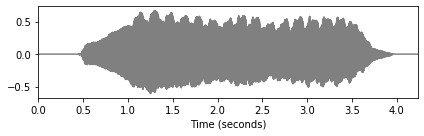

In [1]:
import os
import sys

import numpy as np
from  matplotlib import pyplot as plt
import matplotlib
import librosa
import librosa.display
import IPython.display as ipd

sys.path.append('..')
import LibFMP.B
import LibFMP.C2

%matplotlib inline

# Load wav
fn_wav = os.path.join('..', 'data', 'C2', 'FMP_C2_F05c_C4_violin.wav')

Fs = 11025
x, Fs = librosa.load(fn_wav, sr=Fs)
ipd.Audio(x, rate=Fs)
L = x.shape[0]
t_wav = np.arange(L) / Fs
x_duration = L / Fs

print('t[0] = %0.4f, t[-1] = (L-1)/Fs = %0.4f, Fs = %0.0f, L = %0.0f, dur_x=%0.4f'
      % (t_wav[0], t_wav[-1], Fs, L, x_duration))
ipd.display(ipd.Audio(x, rate=Fs))

plt.figure(figsize=(6, 2))
plt.plot(t_wav, x, color='gray')
plt.xlim([t_wav[0], t_wav[-1]])
plt.xlabel('Time (seconds)')
plt.tight_layout()

The `librosa` function `librosa.display.waveplot` also visualizes the waveform with a physical time axis (given in seconds). Note that, rather than showing the samples of the waveform, this function plots a **symmetric amplitude envelope**. It offers many more functionalities such as plotting stereo signals.

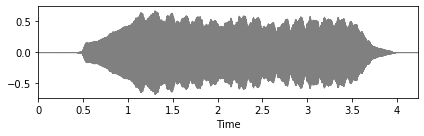

In [2]:
plt.figure(figsize=(6, 2))
librosa.display.waveplot(x, sr=Fs, color='gray')
plt.tight_layout()

A function to plot a waveform is also included in `LibFMP`, which is illustrated by the following code cell.

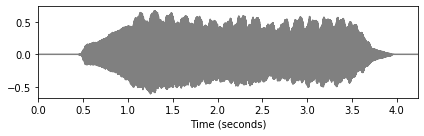

In [3]:
LibFMP.B.plot_signal(x, Fs, figsize=(6, 2));

## Centered Windowing and Time Conversion

When considering a windowed section of the signal, we adopt a **centered** view, where the center of the window is used as reference to relate to the physical domain. In particular, when computing an STFT, we extend the signal to the left by applying [zero padding](../C2/C2_STFT-Padding.html) of half the window length. More precisely, let 
$w:[0:N-1]\to\mathbb{R}$ be a window function of even window length $N\in\mathbb{N}$, and let $H\in\mathbb{N}$ be the hop size. Then we put $N/2$ zero values in front defining:

$$
\tilde{x}=(0,\ldots,0,x(0),x(1), \ldots x(L-1))^\top \in \mathbb{R}^{L+N/2}
$$

and 

\begin{eqnarray}
   \mathcal{X}(m,k):= \sum_{n=0}^{N-1} \tilde{x}(n+mH)w(n)\mathrm{exp}(-2\pi ikn/N).
\end{eqnarray} 

Furthermore, we use the convention that the frame index $m$ is associated to the physical time position

$$
T_\mathrm{coef}(m) := \frac{m\cdot H}{F_\mathrm{s}}
$$

given in seconds. In particular, the following holds:

* The frame index $m=0$ corresponds to the physical time $T_\mathrm{coef}(0)=0$ (given in seconds).
* The time resolution (i.e., the distance between two successive frames) is $\Delta t = H/F_\mathrm{s}$ (given in seconds).

## Frequency Conversion

When $x$ and $w$ are real-valued, the upper half of the frequency coefficients are redundant. Therefore, only the coefficients $k\in[0:K]$ with $K=N/2$ are used. In particular, the index $k=N/2$ corresponds to the Nyquist frequency $\omega=F_\mathrm{s}/2$. Furthermore, the index $k$ corresponds to the frequency 

\begin{equation}
         F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{N} 
\end{equation}

given in Hertz. 

## Spectrogram Visualization

The following code shows how to use the `librosa` function `librosa.stft` to implement these conventions. The parameter setting `center=True` activates the centered view, while `pad_mode='constant'` switches to the zero-padding mode. Furthermore, the code shows how to implement the conversion functions $T_\mathrm{coef}$ and $F_\mathrm{coef}$, once using the formulas above and once using the `librosa` built-in functions. Note that for odd window sizes $N$, there may be different conventions for rounding. In practice, one typically uses **even** window sizes (in particular, being a power of two in view of the [FFT algorithm](../C2/C2_DFT-FFT.html)).

Computation of T_coef agrees: True
Computation of F_coef agrees: True


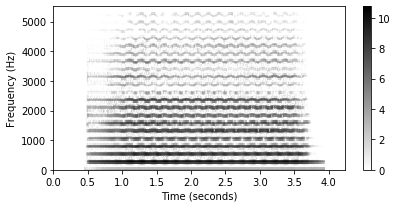

In [4]:
N = 256
H = 64
color = 'gray_r' 

X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True)
Y = np.log(1 + 100 * np.abs(X) ** 2)

T_coef = np.arange(X.shape[1]) * H / Fs
T_coef_librosa = librosa.frames_to_time(np.arange(X.shape[1]), sr=Fs, hop_length=H)
print('Computation of T_coef agrees:', np.allclose(T_coef, T_coef_librosa))

K = N // 2
F_coef = np.arange(K+1) * Fs / N
F_coef_librosa = librosa.fft_frequencies(sr=Fs, n_fft=N)
print('Computation of F_coef agrees:', np.allclose(F_coef, F_coef_librosa))

plt.figure(figsize=(6, 3))
extent = [T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]]
plt.imshow(Y, cmap=color , aspect='auto', origin='lower', extent=extent)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.tight_layout()
plt.show()

To adopt a centered view also in the visualization, one has to adjust the left and right margin by half a frame length, and the lower and upper margin by half a bin width. This is demonstrated by the following code example. For large spectrograms, however, these small adjustments in the visualization are not relevant. 

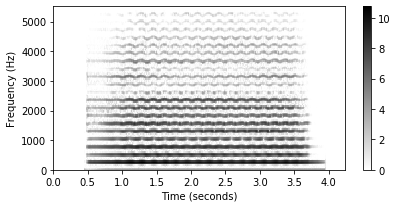

In [5]:
plt.figure(figsize=(6, 3))
extent = [T_coef[0] - (H / 2) / Fs, T_coef[-1] + (H / 2) / Fs,
          F_coef[0] - (Fs / N) / 2, F_coef[-1] + (Fs / N) / 2]
plt.imshow(Y, cmap=color , aspect='auto', origin='lower', extent=extent)
plt.xlim([T_coef[0], T_coef[-1]])
plt.ylim([F_coef[0], F_coef[-1]])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.tight_layout()

Finally, as an alternative, the following code example shows how to use the `librosa`-function  `librosa.display.specshow` to visualize a spectrogram. This function offers many options to modify the visualization. 

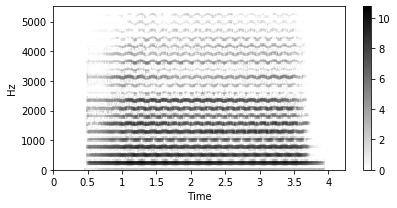

In [6]:
plt.figure(figsize=(6, 3))
librosa.display.specshow(Y, y_axis='linear', x_axis='time', sr=Fs, hop_length=H, cmap=color)
plt.colorbar()
plt.tight_layout()

Functions for computing and visualizing the STFT are also part of `LibFMP`. Furthermore, we included in `LibFMP` the function `stft_conventionFMP`, which is a wrapper of the `librosa` implementation with specific settings as used in the FMP notebooks. Note that the STFT functions may deviate in terms of the padding strategy (in particular, the padding on right side of the signal) and data types used. The following code cell shows how to use the `LibFMP`-functions.

=== Using LibFMP.C2.stft ===
Y.shape = (129, 730), Y.dtype = float64


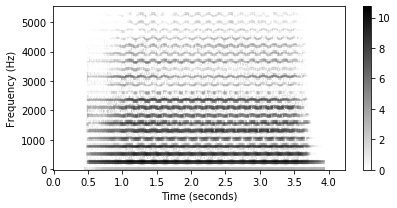

=== Using LibFMP.C2.stft_conventionFMP ===
Y.shape = (129, 730), Y.dtype = float32


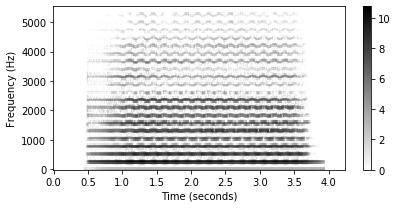

In [7]:
w = np.hanning(N)
X = LibFMP.C2.stft(x, w, H, zero_padding=0, only_positive_frequencies=True)
Y = np.log(1 + 100 * np.abs(X) ** 2)
print('=== Using LibFMP.C2.stft ===')
print('Y.shape = (%d, %d), Y.dtype = %s'%(Y.shape[0], Y.shape[1], Y.dtype))
LibFMP.B.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs);
plt.show()

Y, T_coef, F_coef= LibFMP.C2.stft_conventionFMP(x, Fs, N, H, mag=True, gamma=100)
print('=== Using LibFMP.C2.stft_conventionFMP ===')
print('Y.shape = (%d, %d), Y.dtype = %s'%(Y.shape[0], Y.shape[1], Y.dtype))
LibFMP.B.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs);
plt.show()

## STFT with Increased Frequency Grid Density

We discussed in the <a href="../C2/C2_STFT-FreqGridDensity.html">FMP notebook on frequency grid density</a> how to refine the frequency grid by suitably padding the windowed sections. The `librosa` function `librosa.stft` implements this idea by means of the two parameters `n_fft` (corresponding to $L$, the size of the padded section) and `win_length` (corresponding to $N$, the size of the windowed section). Using this padding variant with $L$ (instead of $N$), one needs to adjust the computation of the function $F_\mathrm{coef}$ as follows:

\begin{equation}
         F_\mathrm{coef}(k) := \frac{k\cdot F_\mathrm{s}}{L} 
\end{equation}

for $k\in [0:K]$ with $K=L/2$. As before, to avoid rounding issues, it is advisable to choose an even number $L$ (possibly, being a power of two).

Computation of F_coef agrees: True
Y.shape = (257,730)


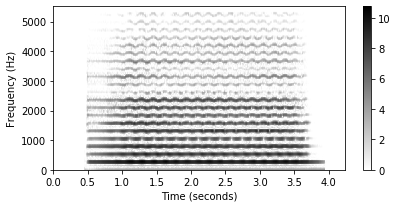

In [8]:
N = 256
L = 512
H = 64
color = 'gray_r' 

X = librosa.stft(x, n_fft=L, hop_length=H, win_length=N, window='hann', pad_mode='constant', center=True)
Y = np.log(1 + 100 * np.abs(X) ** 2)

T_coef = np.arange(0, X.shape[1]) * H / Fs

K = L // 2
F_coef = np.arange(K + 1) * Fs / L
F_coef_librosa = librosa.fft_frequencies(sr=Fs, n_fft=L)
print('Computation of F_coef agrees:', np.allclose(F_coef, F_coef_librosa))
print('Y.shape = (%d,%d)'%(Y.shape[0],Y.shape[1]))

plt.figure(figsize=(6, 3))
extent = [T_coef[0], T_coef[-1], F_coef[0], F_coef[-1]]
plt.imshow(Y, cmap=color , aspect='auto', origin='lower', extent=extent)
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.tight_layout()

Zero padding is also possible with the STFT function from `LibFMP`. However, instead of passing $L$ to the function, it has an argument `zero_padding`, which denotes number $L-N$ of samples to be padded.

Y.shape = (257,730)


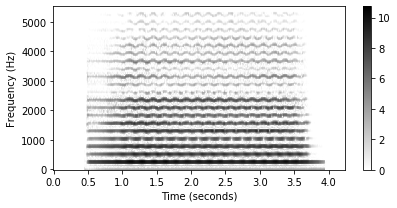

In [9]:
w = np.hanning(N)
X = LibFMP.C2.stft(x, w, H, zero_padding=N, only_positive_frequencies=True)
Y = np.log(1 + 100 * np.abs(X) ** 2)

print('Y.shape = (%d,%d)'%(Y.shape[0],Y.shape[1]))
LibFMP.B.plot_matrix(Y, Fs=Fs/H, Fs_F=(N+N)/Fs);

## Further Notes

There are many further aspects that are crucial when computing and working with the STFT. Among others, we cover in the FMP notebooks the following related topics:

* Inversion of STFT: Reconstructing a time-domain signal from an STFT representation is not straightforward. This topic is covered in Section 8.1.2 of  <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a> as well as in the [FMP notebook on the inverse STFT](../C2/C2_STFT-Inverse.html) and the <a href="../C8/C8S1_SignalReconstruction.html">FMP notebook on signal reconstruction</a>. 
* Instantenous Frequency: The phase information of an STFT can be used to improve the frequency estimation. This topic is covered in Section 8.2.1 of  <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a> and in the <a href="../C8/C8S2_InstantFreqEstimation.html">FMP notebook on instantaneous frequency estimation</a>.


<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a> and <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a>.
</div>  

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>